In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume import PlaneWaveExp, GuidedModeExp, Circle, ShapesLayer, Lattice, PhotCryst
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

In [2]:
# PhC parameters
scale = 1.308

a = 420 * scale
ra = 0.5*256/a * scale       # hole radius
#eps_b = 3.453**2     # slab permittivity for silicon (n ~= 3.453 at low temp, n = 3.48 at room temp)
eps_b = 2.5652**2    # slab permittivity for 4H silicon carbide, 2.5652 for ordinary, 2.6097 for extraordinary
#eps_b = 2.2122**2    # slab permittivity for lithium niobate 2.2122 for ordinary, 2.1385 for extraordinary
eps_c = 1            # hole permittivity
d = 600/(420*scale)         # slab thickness (220nm for )

# plane-wave expansion parameters
gmax = 2     # truncation of the plane-wave basis
Ny = 14      # Number of rows in the y-direction
Ny_opt = 3   # Number of rows in which the pillars will be modified
Nx = 1       # Supercell size in the x-direction

W = 0.94     # Waveguide Width (0.98 in Zhuang)
# W = 1.35      # Coupling into the other mode. Could probably optimise other parameters for this one to have a less steep effective index
# W = 0.98

# Initialize a rectangular lattice
lattice = Lattice([Nx, 0], [0, (Ny+W-1)*np.sqrt(3)/2])

def wg_sc(dx, dy, dr):
    """Define the photonic crystal waveguide given shift parameters
    dx, dy, and dr, for the 2*Nx*Ny_opt number of pillars that get shifted
    """
    phc = PhotCryst(lattice, eps_l = 1, eps_u = 1)
    
    # Initialize a layer and the positions of the pillars for the regular waveguide
    phc.add_layer(d=d, eps_b=eps_b)
    
    xc = []; yc = []
    for ih in range(Ny):
        if ih != Ny//2:
            for ix in range(-Nx//2+1, Nx//2+1):
                xc.append((ih%2)*0.5 + ix)
                if ih <= Ny//2:
                    yc.append((-Ny//2 + ih + (1-W)/2)*np.sqrt(3)/2)
                else:
                    yc.append((-Ny//2 + ih - (1-W)/2)*np.sqrt(3)/2)

    # Add all the pillars, taking care of the shifts
    for ih in range(1, Ny//2+1):
        nx1 = (Ny//2+ih-1)
        nx2 = (Ny//2-ih)
        if ih <= Ny_opt:
            # The ih row includes "optimization" pillars
            for ix in range(Nx):
                circ = Circle(x_cent=xc[nx1*Nx + ix] + dx[(ih-1)*Nx + ix],
                              y_cent=yc[nx1*Nx + ix] + dy[(ih-1)*Nx  + ix],
                              r = ra + dr[(ih-1)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
                circ = Circle(x_cent=xc[nx2*Nx + ix] + dx[(ih-1+Ny_opt)*Nx  + ix],
                              y_cent=yc[nx2*Nx + ix] + dy[(ih-1+Ny_opt)*Nx  + ix],
                              r = ra + dr[(ih-1+Ny_opt)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
        else:
            # The ih row includes just regular pillars
            for ix in range(Nx):
                circ = Circle(x_cent = xc[nx2*Nx + ix], y_cent=yc[nx2*Nx + ix], r=ra, eps=eps_c)
                phc.add_shape(circ)
                if ih < Ny//2:
                    circ = Circle(x_cent = xc[nx1*Nx + ix], y_cent=yc[nx1*Nx + ix], r=ra, eps=eps_c)
                    phc.add_shape(circ)

    # Construct and return a plane-wave expansion object
    return phc

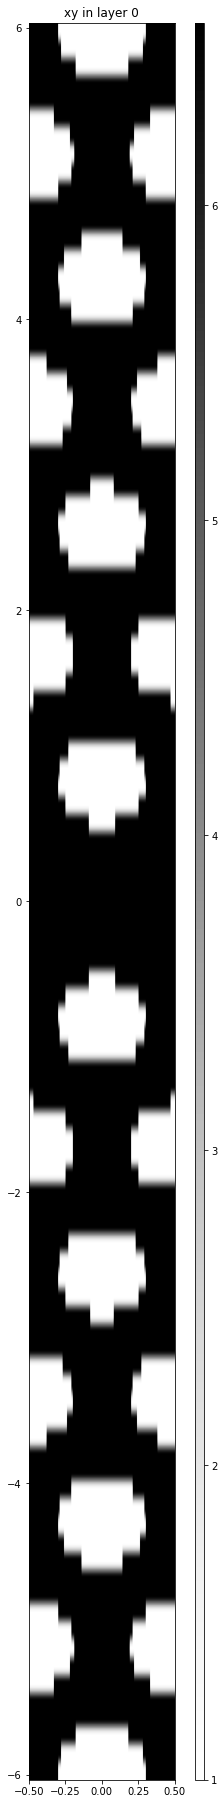

In [3]:
# Initialize zero shifts
dx0 = np.zeros((Nx*2*Ny_opt, ))
dy0 = np.zeros((Nx*2*Ny_opt, ))
dr0 = np.zeros((Nx*2*Ny_opt, ))

# Initialize the PWE and visualize the structure both through the `eps` and the `eps_ft` methods
phc0 = wg_sc(dx0, dy0, dr0)
legume.viz.structure(phc0, xz=False, xy=True, figsize=3)

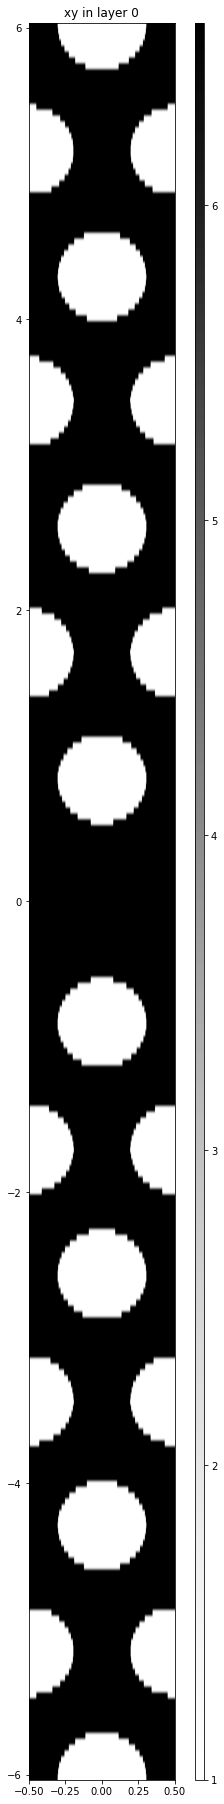

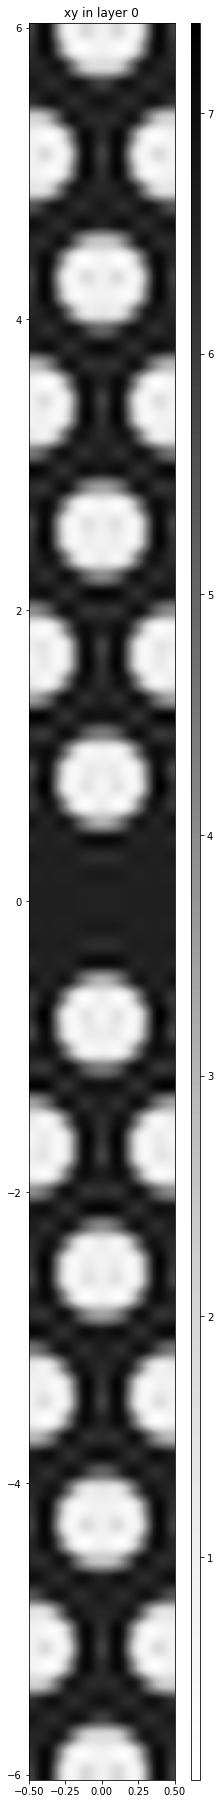

In [4]:
nk = 50

# Define a BZ path in kx
path = phc0.lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [nk])
#pwe0.run(kpoints=path['kpoints'], pol='tm', numeig = 150)
#print(path["kpoints"])

neig = 30

# Initialize GME
gme = legume.GuidedModeExp(phc0, gmax=gmax)

# Set some of the running options
options = {'gmode_inds': [0], #0 for TM modes, I think (H in the z direction, E in the xy plane)
           'numeig': neig,
           'verbose': False
            }

legume.viz.structure(gme, xz=False, xy=True, Nx = 300, Ny = 300, figsize=3)
plt.savefig('unit_cell.eps')
legume.viz.eps_ft(gme, figsize=3)

In [5]:
# Run the simulation
gme.run(kpoints=path['kpoints'], **options)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


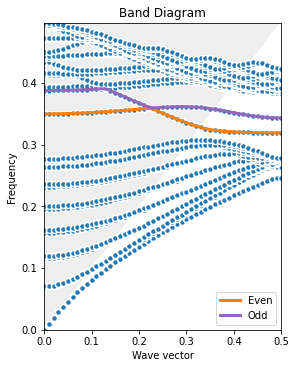

In [6]:
if np.all(gme.kpoints[0,:]==0) and not np.all(gme.kpoints[1,:]==0) \
    or np.all(gme.kpoints[1,:]==0) and not np.all(gme.kpoints[0,:]==0):
    X0 = np.sqrt(
        np.square(gme.kpoints[0, :]) +
        np.square(gme.kpoints[1, :])) / 2 / np.pi
else:
    X0 = np.arange(len(gme.kpoints[0, :]))

# Visualize the bands
ax = legume.viz.bands(gme, Q=False)
ax.plot(X0,gme.freqs[:,14], color = "tab:orange", linewidth=3, label="Even")
ax.plot(X0,gme.freqs[:,15], color = "tab:purple", linewidth=3, label="Odd")
ax.set_title("Band Diagram")
ax.legend()
ax.figure.savefig('bands.eps')

In [7]:
f_ind = np.linspace(0, 1, neig)
k = np.linspace(0, 0.5, nk+1)
fv, kv = np.meshgrid(f_ind, k)
# print(kv)
n_eff = kv/gme.freqs
wvln = a/gme.freqs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


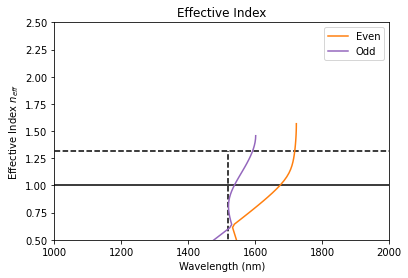

In [8]:
ind = 14 # Index of mode in question

plt.plot([0,10000],[1,1],'k-')  # Light Line
plt.plot([0,10000],[1.32,1.32], 'k--') # neff
#plt.plot([1525,1525],[0,1.44], 'k--') # Wavelength in Question
plt.plot([1518.37,1518.37],[0,1.32], 'k--') # Wavelength in Question
plt.plot(wvln[:,ind], n_eff[:,ind], color = "tab:orange", label="Even")  
plt.plot(wvln[:,15], n_eff[:,15], color = "tab:purple", label="Odd")  
#plt.plot(wvln, n_eff)
#plt.xlim([1380,1540])
plt.xlim([1000,2000])
#plt.xlim([1650,1750])
plt.ylim([0.5,2.5])
plt.xlabel("Wavelength (nm)")
plt.ylabel(r"Effective Index $n_{eff}$")
plt.title("Effective Index")
plt.legend()

plt.savefig("neff.eps")

In [9]:
# Finding where curve crosses the silica line

n_target = 1.32
n_diff = n_target - n_eff[:,ind]
#print(n_diff)
zero_crossings = np.where(np.diff(np.sign(n_diff)))
#print(np.sign(n_diff))
#print(np.diff(np.sign(n_diff)))
#print(zero_crossings)
print(float(wvln[zero_crossings, ind]))  

1717.8224734170615


In [10]:
wvln_target = 1518.37
wvln_ind = wvln[:,ind]    #wvln for the mode in question
n_eff_ind = n_eff[:,ind]  #n_eff for the mode in question

sort = np.argsort(wvln_ind) # Sorting wvln monotonically

wvln_sort = wvln_ind[sort]
n_eff_sort = n_eff_ind[sort]

tck = sc.interpolate.splrep(wvln_sort,n_eff_sort, s=0)
n_eff_wvln = sc.interpolate.splev(wvln_target, tck, der=0) # Interpolate to find nee at wvln_target
print(n_eff_wvln)

-4293.123946923735


In [11]:
type(n_eff_wvln)

numpy.ndarray

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


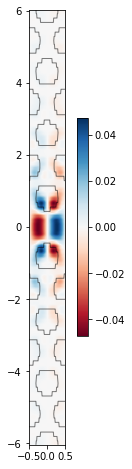

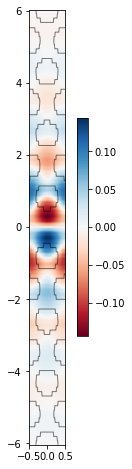

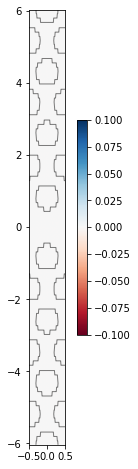

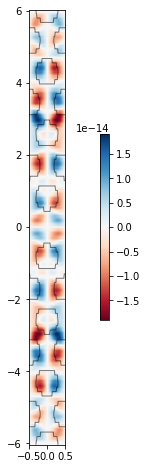

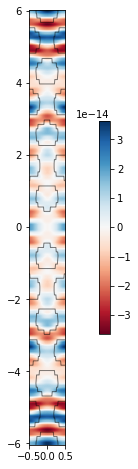

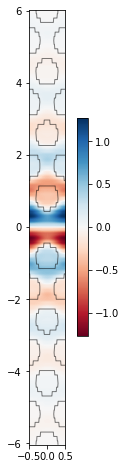

In [12]:
mind = 14
fig1 = legume.viz.field(gme, field = 'e', kind = 20, mind = mind, 
                 #x=0,
                 z=d/2,
                 component='x')
fig1.axes[0].set_title("")
fig1.set_size_inches(2,6.4)
fig1.savefig("Ex.eps")

fig2 = legume.viz.field(gme, field = 'e', kind = 20, mind = mind, 
                 #x=0,
                 z=d/2,
                 component='y')
fig2.axes[0].set_title("")
fig2.set_size_inches(2,6.4)
fig2.savefig("Ey.eps")

fig3 = legume.viz.field(gme, field = 'e', kind = 20, mind = mind, 
                 #x=0,
                 z=d/2,
                 component='z')
fig3.axes[0].set_title("")
fig3.set_size_inches(2,6.4)
fig3.savefig("Ez.eps")

fig4 = legume.viz.field(gme, field = 'h', kind = 20, mind = mind, 
                 #x=0,
                 z=d/2,
                 component='x')
fig4.axes[0].set_title("")
fig4.set_size_inches(2,6.4)
fig4.savefig("Hx.eps")

fig5 = legume.viz.field(gme, field = 'h', kind = 20, mind = mind, 
                 #x=0,
                 z=d/2,
                 component='y')
fig5.axes[0].set_title("")
fig5.set_size_inches(2,6.4)
fig5.savefig("Hy.eps")

fig6 = legume.viz.field(gme, field = 'h', kind = 20, mind = mind, 
                 #x=0,
                 z=d/2,
                 component='z')
fig6.axes[0].set_title("")
fig6.set_size_inches(2,6.4)
fig6.savefig("Hz.eps")